#### 1.IMPORT DEPENDENCIES

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import os
from pathlib import Path
import albumentations as A
from sklearn.model_selection import train_test_split
import shutil
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.models import Model,load_model

In [4]:
dll_directory = r'C:\Users\bkj\Downloads\openslide-win64-20231011\bin'
os.add_dll_directory(dll_directory)
import openslide


In [97]:
PATH = {
    'data': Path('data'),
    'image':Path('data','image'),
    'train': Path('data','train'),
    'test': Path('data','test'),
}

for x in PATH:
    PATH[x].mkdir(exist_ok=True)

#### 2.GET IMAGES OUT OF .SVS file

In [7]:
### lower dimension extraction

def get_images_from_svs(svs_file_path,filename):
    '''This function will extract images from the SVS file 
    
    Arguments:
        svs_file_path: this is the path to the .svs file
        filename: image will be saved with this filename'''
    
    slide = openslide.open_slide(svs_file_path)
    x, y = 0, 0
    # width, height = 1000, 1000 
    level = 0
    width,height = slide.dimensions
    image = slide.read_region((x, y), level, (width, height))
    image.save(f"{filename}.png",'PNG')
    slide.close

svs_filename = ['DI-MH-694-08','DI-MH-226-11','DI-MH-694-04','DI-MH-226-08',
                'DI-MH-694-01','DI-MH-226-10','DI-MH-694-09','DI-MH-226-07']
for filename in svs_filename:
    print(filename)
    svs_file_path = rf'C:\Users\bkj\Downloads\{filename}.svs'
    Path('image').mkdir(exist_ok=True)
    get_images_from_svs(svs_file_path=svs_file_path,filename=Path('image',filename))


DI-MH-694-08


MemoryError: 

In [98]:
def get_images_from_svs(svs_file_path,filename):
    '''This function will extract images from the SVS file 
    
    Arguments:
        svs_file_path: this is the path to the .svs file
        filename: image will be saved with this filename'''
    
    slide = openslide.OpenSlide(svs_file_path)
    width,height = slide.dimensions
    thumbnail = slide.get_thumbnail((256,256))
    thumbnail.save(f"{filename}.jpg",'JPEG')
    slide.close

svs_filename = ['DI-MH-694-08','DI-MH-226-11','DI-MH-694-04','DI-MH-226-08',
                'DI-MH-694-01','DI-MH-226-10','DI-MH-694-09','DI-MH-226-07']
for filename in svs_filename:
    print(filename)
    svs_file_path = rf'C:\Users\bkj\Downloads\{filename}.svs'
    get_images_from_svs(svs_file_path=svs_file_path,filename=Path('data','image',filename))

DI-MH-694-08
DI-MH-226-11
DI-MH-694-04
DI-MH-226-08
DI-MH-694-01
DI-MH-226-10
DI-MH-694-09
DI-MH-226-07


#### 3.GET IMAGES AND LABELS

In [3]:
def create_datasets(pattern):
    dataset = tf.data.Dataset.list_files(pattern)
    dataset = dataset.map(load_images)
    return dataset

def load_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img


dataset = create_datasets('data/image/*.jpg')
dataset

<_MapDataset element_spec=TensorSpec(shape=(None, None, None), dtype=tf.uint8, name=None)>

In [4]:
image = dataset.as_numpy_iterator().next()
image

array([[[243, 243, 243],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [243, 243, 243]],

       [[243, 243, 243],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [243, 243, 243]],

       [[243, 243, 243],
        [242, 242, 242],
        [242, 242, 242],
        ...,
        [242, 242, 242],
        [242, 242, 242],
        [243, 243, 243]],

       ...,

       [[241, 242, 244],
        [234, 235, 237],
        [246, 246, 248],
        ...,
        [241, 243, 240],
        [241, 240, 238],
        [242, 238, 237]],

       [[241, 243, 242],
        [241, 243, 242],
        [242, 242, 242],
        ...,
        [243, 245, 244],
        [245, 244, 242],
        [234, 230, 229]],

       [[241, 243, 242],
        [241, 243, 242],
        [242, 242, 242],
        ...,
        [242, 244, 243],
        [244, 243, 241],
        [233, 229, 228]]

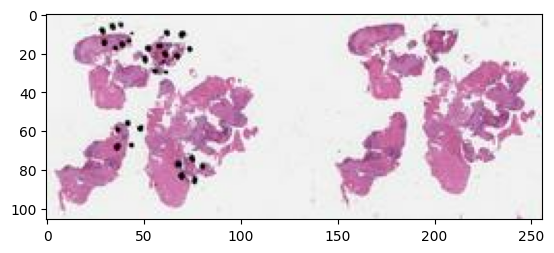

In [5]:
plt.imshow(image)

#### 4. Split images to train,test and val

In [102]:
image_list = [x for x in Path(PATH['image']).glob('*.jpg')]

train_list, test_list = train_test_split(image_list,test_size=0.2,random_state=42)

for loc in [train_list,test_list]:
    for file in loc:
        if loc == train_list:
            shutil.copy(file,PATH['train'])
        else:
            shutil.copy(file,PATH['test'])

In [23]:
test_list

[WindowsPath('data/image/DI-MH-226-08.jpg'),
 WindowsPath('data/image/DI-MH-694-04.jpg')]

#### 5.DATA AUGMENTATIION
we will create more data from what we have by using the albumentation library. This will add random effect such and bright,contrast,image rotation and flips and many more to produce variance of the data we already have

In [103]:
augmentor = A.Compose(
    [
        A.HorizontalFlip(0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.RGBShift(p=0.2),
        A.VerticalFlip(p=0.5)
    ]
)

In [104]:
aug_img = augmentor(image=image)

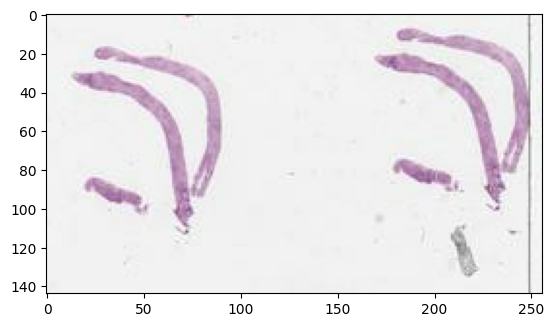

In [105]:
plt.imshow(aug_img['image'])

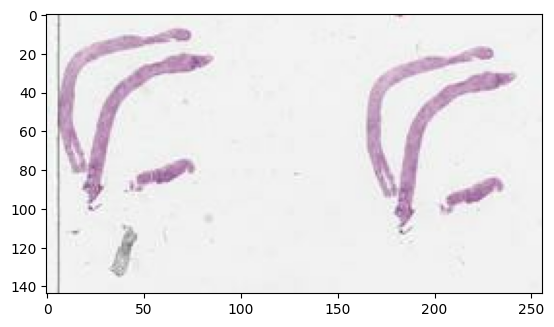

In [106]:
plt.imshow(image)

In [8]:
LABEL_DICT = {'DI-MH-226-07':1,'DI-MH-226-08':0,'DI-MH-226-10':0,'DI-MH-226-11':0,
              'DI-MH-694-01':1,'DI-MH-694-04':1,'DI-MH-694-08':1,'DI-MH-694-09':1}
LABEL_DICT

{'DI-MH-226-07': 1,
 'DI-MH-226-08': 0,
 'DI-MH-226-10': 0,
 'DI-MH-226-11': 0,
 'DI-MH-694-01': 1,
 'DI-MH-694-04': 1,
 'DI-MH-694-08': 1,
 'DI-MH-694-09': 1}

In [160]:
# Define path to save augmented images

AUG_PATH = {
    'aug_data': Path('aug_data'),
    'train': Path('aug_data','train'),
    'test': Path('aug_data','test')
}

for x in AUG_PATH:
    AUG_PATH[x].mkdir(exist_ok=True)

In [186]:
# 80 augmented images of each original
number_augmented_images = 800

for loc in ['train','test']:
    image_list = [x for x in PATH[loc].glob('*.jpg')]
    for image in image_list:
        for i in range(number_augmented_images):
            image_array = cv2.imread(rf'{image}')
            augmented_image = augmentor(image=image_array)['image']
            if loc == 'train':
                path_to_save_augmented = Path(AUG_PATH['train'],f"{image.stem}_{i}.jpg")
            else:
                path_to_save_augmented = Path(AUG_PATH['test'],f"{image.stem}_{i}.jpg")
            
            
            cv2.imwrite(str(path_to_save_augmented),augmented_image)

#### 6.CREATE DATASET WITH LABELS

In [9]:
def create_datasets(directory):
    # get images
    image_names = tf.data.Dataset.list_files(os.path.join(directory,'*.jpg'),shuffle=False)
    images = image_names.map(read_images)

    # create labels
    image_filenames = list(image_names.as_numpy_iterator())
    labels = [LABEL_DICT[Path(i.decode()).stem[:12]] for i in image_filenames]
    assert len(images) == len(labels)

    labels_dataset = tf.data.Dataset.from_tensor_slices(labels)
    dataset = tf.data.Dataset.zip((images,labels_dataset))
    dataset = dataset.shuffle(5000)
    dataset = dataset.batch(8)
    dataset = dataset.prefetch(4)
    return dataset

def read_images(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img,(120,120))
    img /= 255
    return img

tumor_detection_dataset = create_datasets('aug_data/train/')
tumor_detection_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 120, 120, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
tensor_data = tumor_detection_dataset.as_numpy_iterator()

In [11]:
y = tensor_data.next()
y

(array([[[[0.94509804, 0.94509804, 0.94509804],
          [0.94235295, 0.94235295, 0.94235295],
          [0.9372549 , 0.9372549 , 0.9372549 ],
          ...,
          [0.9490196 , 0.9490196 , 0.9411765 ],
          [0.9490196 , 0.9490196 , 0.9411765 ],
          [0.9490196 , 0.9490196 , 0.9411765 ]],
 
         [[0.9430147 , 0.9430147 , 0.9430147 ],
          [0.94125   , 0.94125   , 0.94125   ],
          [0.9372549 , 0.9372549 , 0.9372549 ],
          ...,
          [0.9490196 , 0.9490196 , 0.9411765 ],
          [0.9490196 , 0.9490196 , 0.9411765 ],
          [0.9490196 , 0.9490196 , 0.9411765 ]],
 
         [[0.9428758 , 0.9428758 , 0.9428758 ],
          [0.9411765 , 0.9411765 , 0.9411765 ],
          [0.9378404 , 0.9378404 , 0.9378404 ],
          ...,
          [0.9490196 , 0.9490196 , 0.9411765 ],
          [0.9490196 , 0.9490196 , 0.9411765 ],
          [0.9490196 , 0.9490196 , 0.9411765 ]],
 
         ...,
 
         [[0.94509804, 0.94509804, 0.94509804],
          [0.94509

In [12]:
LABEL_DICT

{'DI-MH-226-07': 1,
 'DI-MH-226-08': 0,
 'DI-MH-226-10': 0,
 'DI-MH-226-11': 0,
 'DI-MH-694-01': 1,
 'DI-MH-694-04': 1,
 'DI-MH-694-08': 1,
 'DI-MH-694-09': 1}

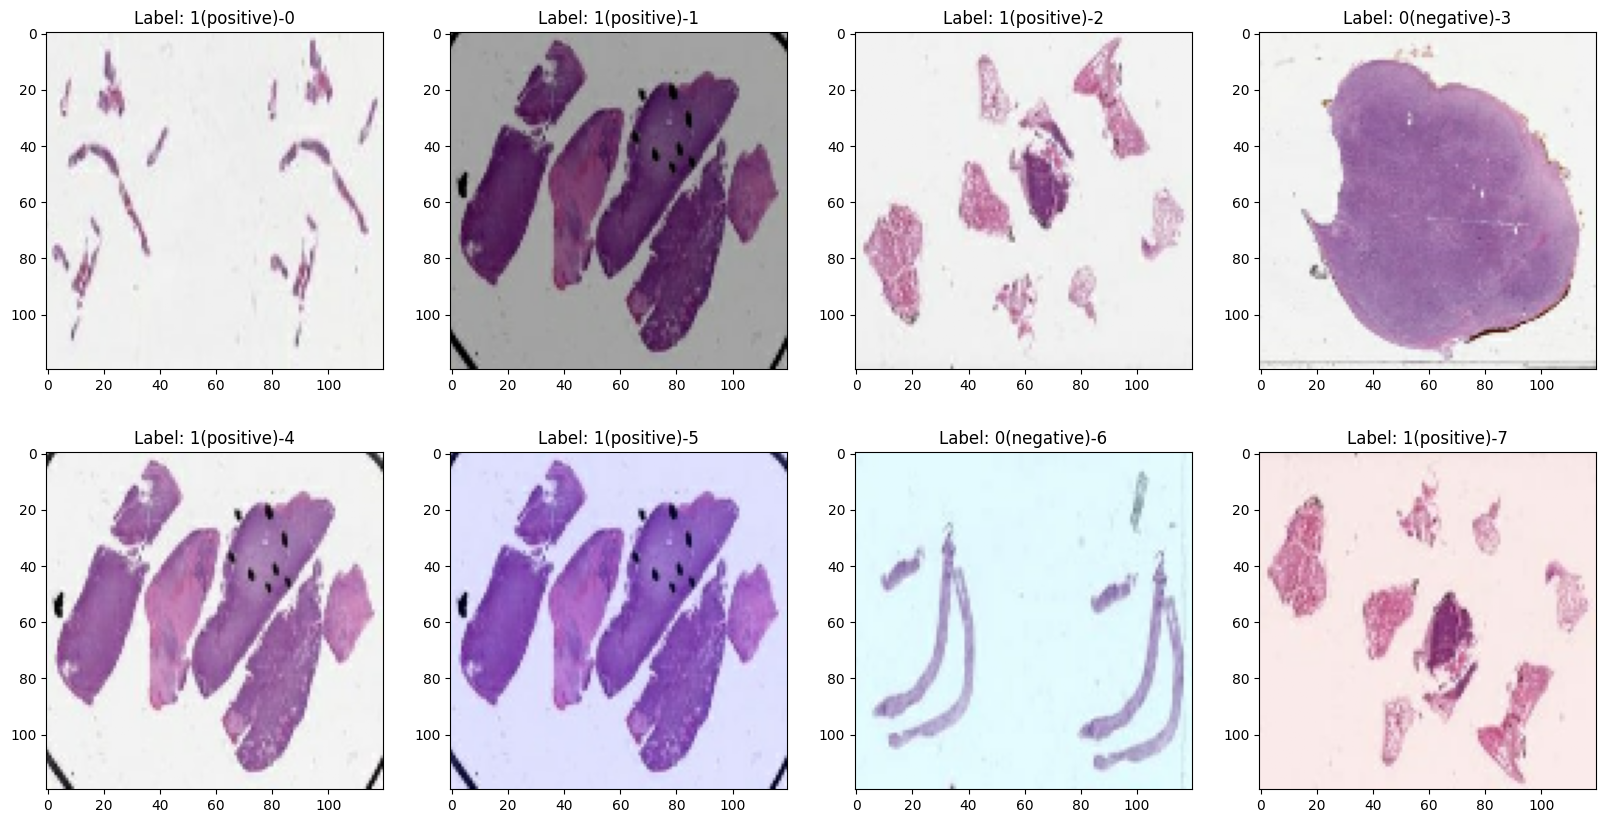

In [13]:



def plot_images_with_labels(x):
    fig,axes = plt.subplots(ncols=4,nrows=2,figsize=(20,10))
    images = x[0]
    labels = x[1]
    label_key = {1:'positive',0:'negative'}
    for i in range(8):
        row = i // 4
        col = i % 4
        img = images[i]
        axes[row,col].imshow(img)
        axes[row, col].set_title(f"Label: {labels[i]}({label_key[labels[i]]})-{i}")

plot_images_with_labels(y)


#### 7.BUILD MODEL

In [14]:
NUM_EPOCHS = 1
BATCH_SIZE = 64

In [21]:
test_dataset = create_datasets('aug_data/test/')
test_dataset = test_dataset.as_numpy_iterator()

In [22]:
x = test_dataset.next()

##### 7.1 EfficientNetB0 model

In [195]:

base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [196]:
model.fit(tumor_detection_dataset, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

# for layer in base_model.layers:
#     layer.trainable = True

# model.fit(tumor_detection_dataset, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

116/600 [====>.........................] - ETA: 14:04 - loss: 0.1319 - accuracy: 0.9752

KeyboardInterrupt: 

In [203]:
x

(array([[[[0.84915036, 0.84013075, 0.83398694],
          [0.847451  , 0.85843134, 0.85568625],
          [0.8366013 , 0.85882354, 0.851634  ],
          ...,
          [0.8620914 , 0.8620914 , 0.8620914 ],
          [0.85647047, 0.86392164, 0.87058824],
          [0.8453594 , 0.8644445 , 0.8666667 ]],
 
         [[0.8519543 , 0.84293467, 0.83679086],
          [0.84648037, 0.8574608 , 0.8547157 ],
          [0.8339052 , 0.85612744, 0.84893787],
          ...,
          [0.8620914 , 0.8566994 , 0.8593954 ],
          [0.85614705, 0.85842174, 0.86605895],
          [0.84492815, 0.8612092 , 0.8648334 ]],
 
         [[0.85773414, 0.8487146 , 0.84257084],
          [0.848219  , 0.8611438 , 0.8508987 ],
          [0.8333333 , 0.8555556 , 0.848366  ],
          ...,
          [0.87042475, 0.8546296 , 0.86669385],
          [0.8633008 , 0.8522552 , 0.86482054],
          [0.8488182 , 0.8545971 , 0.8612965 ]],
 
         ...,
 
         [[0.8606754 , 0.8606754 , 0.8606754 ],
          [0.85916

In [205]:
threshold = 0.64

In [206]:
y_pred = model.predict(x[0])
y_pred = (y_pred > threshold).astype('int')
y_pred

1/1 [==============================] - 0s 472ms/step


array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [207]:
model.save('efficientnetB0.h5')

c:\Users\bkj\Documents\GitHub\projects\computer vision\cv-env\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### 7.2 ResNet model

In [17]:

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tune the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [18]:
model.fit(tumor_detection_dataset, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

195/600 [========>.....................] - ETA: 14:08 - loss: 0.0269 - accuracy: 0.9885

KeyboardInterrupt: 

In [23]:
x

(array([[[[0.9137255 , 0.94509804, 0.9882353 ],
          [0.9073562 , 0.9387288 , 0.98186606],
          [0.9092211 , 0.94059366, 0.9837309 ],
          ...,
          [0.92156863, 0.9529412 , 0.99607843],
          [0.92156863, 0.9529412 , 0.99607843],
          [0.92156863, 0.9529412 , 0.99607843]],
 
         [[0.9142778 , 0.94565034, 0.9887876 ],
          [0.9110784 , 0.94245094, 0.98558825],
          [0.9110784 , 0.94245094, 0.98558825],
          ...,
          [0.92156863, 0.9529412 , 0.99607843],
          [0.92156863, 0.9529412 , 0.99607843],
          [0.92156863, 0.9529412 , 0.99607843]],
 
         [[0.91450435, 0.9458769 , 0.98901415],
          [0.9158497 , 0.94722223, 0.9903595 ],
          [0.9158497 , 0.94722223, 0.9903595 ],
          ...,
          [0.92156863, 0.9529412 , 0.99607843],
          [0.92156863, 0.9529412 , 0.99607843],
          [0.92156863, 0.9529412 , 0.99607843]],
 
         ...,
 
         [[0.9098039 , 0.9411765 , 0.9843137 ],
          [0.90980

In [24]:
y_pred = model.predict(x[0])
y_pred

1/1 [==============================] - 3s 3s/step


array([[1.9787271e-05],
       [2.5872289e-06],
       [2.5872289e-06],
       [8.6963264e-06],
       [2.1067170e-05],
       [1.4674830e-05],
       [2.2240349e-05],
       [2.5872362e-06]], dtype=float32)

In [20]:
x

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense')>

In [ ]:

import openslide
from PIL import Image

# Open the .svs file
svs_image = openslide.open_slide('your_image.svs')

# Convert a region of the slide to a PIL image
region = svs_image.read_region((0, 0), 0, svs_image.level_dimensions[0])
region = region.convert('RGB')

# Save the region as a .png
region.save('your_image.png')
